# 使用块的网络 VGG

### 网络结构
![VGG](./src/VGG.png)

使用多个小卷积核来代替大的卷积核

将多个3*3卷积层（填充1，n层，m通道），2*2最大池化层（步幅2）组成一个VGG块，使用更多的3*3比使用对应的5*5卷积核效果更好

多个VGG块后连接全连接层，不同次数的重复得到不同的架构（VGG-16，VGG-19）


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

使用VGG块构建VGG网络

图像只使用一通道的灰度图

In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(*conv_blks, nn.Flatten(),
                         nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
                         nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
                         nn.Dropout(0.5), nn.Linear(4096, 10))

net = vgg(conv_arch)

观察每一层的输出形状

In [3]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络

In [4]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

模型训练

loss 0.094, train acc 0.966, test acc 0.931
299.7 examples/sec on cuda:0


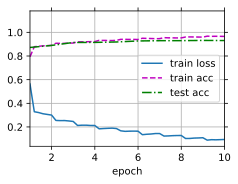

In [5]:
lr, num_epochs, batch_size = 0.05, 10, 32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
